for misc testing

In [40]:
import numpy as np
import pandas as pd
import xarray as xr
from geopy.distance import distance
import matplotlib.pyplot as plt

In [15]:
home = "/mnt/g/My Drive/GTC/solodoch_data_full/60S"
vm = xr.open_mfdataset(f"{home}/ECCO_L4_OCEAN_VEL_05DEG_MONTHLY_V4R4/*nc",
                        coords="minimal",
                        data_vars="minimal",
                        parallel=True, compat="override")
vm = vm[["NVEL"]].transpose("longitude", "latitude", "Z", "time")
vm = vm.rename({"NVEL": "vm"})
ve = xr.open_mfdataset(f"{home}/ECCO_L4_BOLUS_05DEG_MONTHLY_V4R4/*nc",
                        coords="minimal",
                        data_vars="minimal",
                        parallel=True, compat="override")
ve = ve[["NVELSTAR"]].transpose("longitude", "latitude", "Z", "time")
ve = ve.rename({"NVELSTAR": "ve"})

In [16]:
data = xr.merge([vm, ve], join="inner")
lat = data["latitude"].to_numpy()[0]
lons = data["longitude"].to_numpy()
Z = np.flip(data["Z"].to_numpy())[:-1]
coords = [(lat, lon) for lon in lons]

In [25]:
d_lon = [distance(coords[i-1], coords[i]).meters for i in range(1, len(coords))]
d_z = np.diff(np.flip(data["Z"].to_numpy()))

In [47]:
d_lon

[28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920703733,
 28110.163920

In [48]:
vm = data["vm"].to_numpy(); vm = np.nan_to_num(vm)
ve = data["ve"].to_numpy(); ve = np.nan_to_num(ve)

vm = np.flip(vm, axis=2)
ve = np.flip(vm, axis=2)

v = vm + ve
v = v[:-1, :, :-1, :]

In [49]:
def psi(depth):
    ix = list(Z).index(depth)
    inner_integral = np.tensordot(v[:, :, :ix, :], d_z[:ix], axes=([2], [0]))
    outer_integral = np.tensordot(inner_integral, d_lon, axes=([0], [0]))
    return -outer_integral.squeeze()

In [53]:
depth = Z[0]
ix = list(Z).index(depth)
inner_integral = np.tensordot(v[:, :, :ix, :], d_z[:ix], axes=([2], [0]))

array([-5906.25 , -5461.25 , -5039.25 , -4640.25 , -4264.25 , -3911.25 ,
       -3581.25 , -3274.25 , -2990.25 , -2729.25 , -2491.25 , -2276.225,
       -2084.035, -1914.15 , -1765.135, -1634.175, -1517.095, -1409.15 ,
       -1306.205, -1205.535, -1105.905, -1007.155,  -909.74 ,  -814.47 ,
        -722.4  ,  -634.735,  -552.71 ,  -477.47 ,  -409.93 ,  -350.68 ,
        -299.93 ,  -257.47 ,  -222.71 ,  -194.735,  -172.4  ,  -154.47 ,
        -139.74 ,  -127.15 ,  -115.87 ,  -105.31 ,   -95.095,   -85.025,
         -75.005,   -65.   ,   -55.   ,   -45.   ,   -35.   ,   -25.   ,
         -15.   ], dtype=float32)

In [50]:
streamfunction = [psi(z) for z in Z]
streamfunction = np.vstack(streamfunction)
ts = -1
single_timestep = streamfunction[:, ts]

df = pd.DataFrame()
df["depth"] = Z
df["sf"] = single_timestep

In [51]:
display(df.head(2))
display(df.tail(2))

,depth,sf
0,-5906.25,-0.0
1,-5461.25,-0.0


,depth,sf
47,-25.0,5.393403e+06
48,-15.0,3.781045e+06


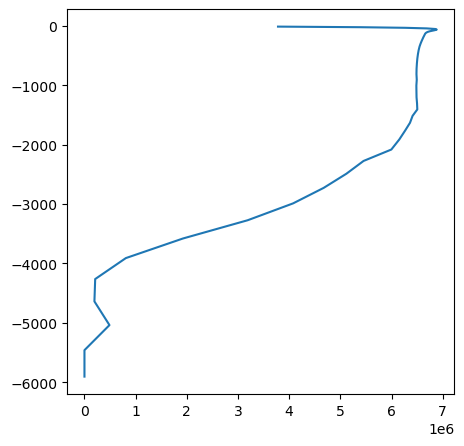

In [52]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(df["sf"], df["depth"])
plt.show()

In [33]:
# out = [psi(z) for z in Z]
# out = [abs(x.mean()) for x in out]
# max(out)

750546001.5416402